In [1]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00


In [61]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00


In [141]:
import pandas as pd
import requests
import json
import re
import random
import plotly.express as px
import tiktoken

In [3]:
try:
  df = pd.read_excel('/content/2022(3).xlsx', sheet_name = 'category')
except Exception as e:
  print(f'Ошибка: {e}')

 # Распределения по кол-ву элементов в заявке

In [4]:
df.head(10)

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма,Комплектность
0,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,Лакокрасочные материалы,22254978,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,2.0,шт,370.000,True,0.2,740.00,NaN
1,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,Лакокрасочные материалы,22254977,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,1.0,шт,1088.500,True,0.2,1088.50,NaN
2,260823946,ACCEPTED_BY_ACCEPTORS,2022-05-06 03:00:00,г. Санкт-Петербург,56724.0,"ООО ""СЭТЛ СТРОЙ""",54849.0,"АО ""БЕАТОН""",12895635,13019010,...,"Асфальт, тротуарная плитка",22254979,"Пористая крупнозернистая марка 2 (гранит, БНД)...",240.0,т,3720.000,True,0.2,892800.00,NaN
3,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978030,...,СИЗ,22254982,ПЕРЧАТКИ х/б двойной облив,300.0,пара,27.400,True,0.2,8220.00,NaN
4,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978034,...,Инструмент ручной,22254985,"ФОНАРЬ налобный, светодиодный, аккумуляторный",10.0,шт,379.665,True,0.2,3796.65,NaN
5,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978028,...,Кабели с медной жилой,22254980,ВИЛКА 2P+E 1*16A каучук IP44,25.0,шт,63.800,True,0.2,1595.00,NaN
6,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978033,...,СИЗ,22254984,МАСКА СВАРЩИКА FUBAG OPTIMA Visor Silver (4-8/...,5.0,шт,5875.000,True,0.2,29375.00,NaN
7,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978029,...,СИЗ,22254981,КРАГИ спилковые,50.0,пара,240.000,True,0.2,12000.00,NaN
8,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978031,...,СИЗ,22254983,СТЕКЛО покровное 121*69 мм,50.0,шт,14.420,True,0.2,721.00,NaN
9,260823991,NEW,2022-05-06 03:00:00,г. Санкт-Петербург,50334.0,"ООО ""СТРОЙ ПРОГРЕСС""",118503.0,"ООО ""СКС""",12889037,12993401,...,Санфаянс,22254989,"Тумба под раковину Next 60, подвесная, 2 ящика...",55.0,шт,6500.000,True,0.2,357500.00,NaN


In [5]:
df.iloc[0]

,0
ID счета,260823883
state,PAID
Дата счета,2022-05-06 03:00:00
Регион,Чувашская Республика
ID плательщика,384042.0
Название плательщика,"ООО ""СК-ЛЕРОН"""
ID поставщика,127773.0
Название поставщика,"ООО ""ТПП ""ТЕХНОДЕКОР"""
ID заявки,12864133
ID позиции заявки,12897510


In [6]:
df.iloc[1]

,1
ID счета,260823883
state,PAID
Дата счета,2022-05-06 03:00:00
Регион,Чувашская Республика
ID плательщика,384042.0
Название плательщика,"ООО ""СК-ЛЕРОН"""
ID поставщика,127773.0
Название поставщика,"ООО ""ТПП ""ТЕХНОДЕКОР"""
ID заявки,12864133
ID позиции заявки,12897510


In [7]:
df.iloc[2]['Название в заявке']

'Смесь асфальтобетонная крупнозернистая пористая марка II'

In [8]:
df.iloc[2]['Название в счете']

'Пористая крупнозернистая марка 2 (гранит, БНД) - а/б смесь'

In [9]:
# не рассматриваем примеры с комплектностью
df = df[df['Комплектность'].isna()].drop(['Комплектность'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468587 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID счета              468587 non-null  int64  
 1   state                 468587 non-null  object 
 2   Дата счета            468587 non-null  object 
 3   Регион                468585 non-null  object 
 4   ID плательщика        468586 non-null  float64
 5   Название плательщика  468576 non-null  object 
 6   ID поставщика         466423 non-null  float64
 7   Название поставщика   463985 non-null  object 
 8   ID заявки             468587 non-null  int64  
 9   ID позиции заявки     468587 non-null  int64  
 10  Название в заявке     468585 non-null  object 
 11  Кол-во в заявке       468587 non-null  float64
 12  ЕИ позиции заявки     468587 non-null  object 
 13  Категория             466590 non-null  object 
 14  ID позиции счета      468587 non-null  int64  
 15  Назва

In [10]:
df.iloc[0]

,0
ID счета,260823883
state,PAID
Дата счета,2022-05-06 03:00:00
Регион,Чувашская Республика
ID плательщика,384042.0
Название плательщика,"ООО ""СК-ЛЕРОН"""
ID поставщика,127773.0
Название поставщика,"ООО ""ТПП ""ТЕХНОДЕКОР"""
ID заявки,12864133
ID позиции заявки,12897510


In [11]:
 df[['Название в заявке', 'Название в счете']].head(10)

,Название в заявке,Название в счете
0,Грунт-эмаль 3 в.1 по ржавчине,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...
1,Грунт-эмаль 3 в.1 по ржавчине,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...
2,Смесь асфальтобетонная крупнозернистая пориста...,"Пористая крупнозернистая марка 2 (гранит, БНД)..."
3,Перчатки с двойным латексным покрытием,ПЕРЧАТКИ х/б двойной облив
4,Налобный фонарь ЯРКИЙ ЛУЧ LH-180 ACCU,"ФОНАРЬ налобный, светодиодный, аккумуляторный"
5,Кабель ПВС 2*1.5 ВМЕСТО КАБЕЛЯ приобрести \t\n...,ВИЛКА 2P+E 1*16A каучук IP44
6,"Маска сварщика хамелеон ,РАЗМЕР СВЕТОФИЛЬТРА: ...",МАСКА СВАРЩИКА FUBAG OPTIMA Visor Silver (4-8/...
7,Краги для сварщика (красные),КРАГИ спилковые
8,"Стекло защитное прозрачное, РАЗМЕР: 120 х 70 мм",СТЕКЛО покровное 121*69 мм
9,#_Тумба под умывальник,"Тумба под раковину Next 60, подвесная, 2 ящика..."


In [12]:
dict_appl = {}
for i in df['ID заявки'].unique():
  ff = df[df['ID заявки'] == i]
  dict_appl[i] = len(ff['ID позиции заявки'].unique())

In [13]:
n_products_new = pd.DataFrame(dict_appl.values())
n_products = n_products_new.copy()
n_products

,0
0,27
1,1
2,6
3,2
4,1
...,...
35550,1
35551,4
35552,1
35553,2


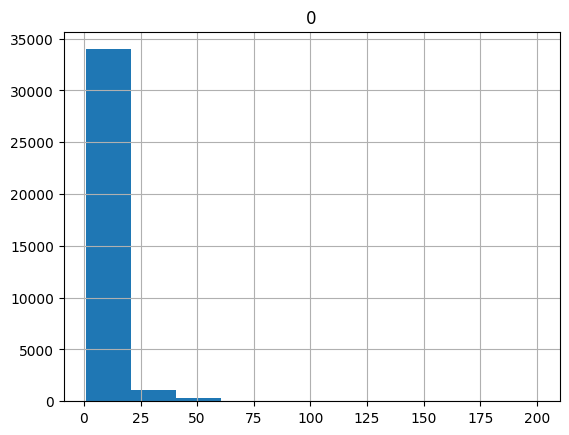

In [14]:
# n_products = df[['ID заявки', 'ID позиции заявки']].groupby('ID заявки').count()
n_products.hist();

In [15]:
n_products.describe()

,0
count,35555.000000
mean,5.100211
std,9.497198
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,200.000000


In [16]:
fig = px.box(n_products)
fig.show()

In [17]:
n_products = n_products.rename(columns={0: 'Количество товаров в заявке'})

In [18]:
fig = px.histogram(n_products,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=5,
        title='Количество товаров'
    )
)
fig.show()

In [19]:
# оставляем данные, где количество не превышает верхней границы
n_products_down = n_products[n_products['Количество товаров в заявке'] <= 11]
n_products_down.describe()

,Количество товаров в заявке
count,31850.000000
mean,2.766531
std,2.508974
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


In [20]:
fig = px.histogram(n_products_down,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=1,
        title='Количество товаров'
    )
)
fig.show()

In [21]:
n_products_up = n_products[n_products['Количество товаров в заявке'] > 11]

fig = px.histogram(n_products_up,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=50,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=5,
        title='Количество товаров'
    )
)
fig.show()

In [22]:
n_products[n_products['Количество товаров в заявке'] > 199]

,Количество товаров в заявке
23209,200


In [23]:
df[df['ID заявки'] == 23209]

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,ЕИ позиции заявки,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма


In [24]:
n_products_mid = n_products[(n_products['Количество товаров в заявке'] > 1) & (n_products['Количество товаров в заявке'] <= 11)]
n_products_mid.describe()

,Количество товаров в заявке
count,16620.000000
mean,4.385319
std,2.565801
min,2.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,11.000000


In [25]:
fig = px.histogram(n_products_mid,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=1,
        title='Количество товаров'
    )
)
fig.show()

# Формировавние тестовой выборки

In [26]:
arr_ones_id = []

for id in dict_appl:
  if dict_appl[id] == 1:
    arr_ones_id.append(id)

print(f'Количество заявок с 1 товаром: {len(arr_ones_id)}')

Количество заявок с 1 товаром: 15230


In [27]:
df_new = df[~df['ID заявки'].isin(arr_ones_id)]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436818 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID счета              436818 non-null  int64  
 1   state                 436818 non-null  object 
 2   Дата счета            436818 non-null  object 
 3   Регион                436816 non-null  object 
 4   ID плательщика        436817 non-null  float64
 5   Название плательщика  436811 non-null  object 
 6   ID поставщика         434782 non-null  float64
 7   Название поставщика   432738 non-null  object 
 8   ID заявки             436818 non-null  int64  
 9   ID позиции заявки     436818 non-null  int64  
 10  Название в заявке     436818 non-null  object 
 11  Кол-во в заявке       436818 non-null  float64
 12  ЕИ позиции заявки     436818 non-null  object 
 13  Категория             435008 non-null  object 
 14  ID позиции счета      436818 non-null  int64  
 15  Назва

In [28]:
value_counts = df['Категория'].value_counts()
pd.set_option('display.max_rows', None)
print(value_counts)
pd.reset_option('display.max_rows')

Категория
Метизы                                                                  39581
Воздуховоды и фасонные изделия                                          39153
Инструмент ручной                                                       24639
Кабели с медной жилой                                                   20960
Расходные материалы для инструмента (буры, биты, диски)                 19017
Запорно-регулирующая трубопроводная арматура                            17922
Арматура                                                                17100
Детали трубопровода                                                     11187
СИЗ                                                                      8614
Металлические трубы (черные)                                             8500
Электроустановочная продукция                                            8467
Полипропиленовые трубы (ППР)                                             7689
Противопожарные клапаны                               

In [29]:
# оставим только те данные, где была произведена оплата (state == PAID)
df_new = df_new[df_new.state == 'PAID']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59249 entries, 0 to 499925
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              59249 non-null  int64  
 1   state                 59249 non-null  object 
 2   Дата счета            59249 non-null  object 
 3   Регион                59249 non-null  object 
 4   ID плательщика        59249 non-null  float64
 5   Название плательщика  59243 non-null  object 
 6   ID поставщика         59243 non-null  float64
 7   Название поставщика   57654 non-null  object 
 8   ID заявки             59249 non-null  int64  
 9   ID позиции заявки     59249 non-null  int64  
 10  Название в заявке     59249 non-null  object 
 11  Кол-во в заявке       59249 non-null  float64
 12  ЕИ позиции заявки     59249 non-null  object 
 13  Категория             58141 non-null  object 
 14  ID позиции счета      59249 non-null  int64  
 15  Название в счете      5

In [30]:
def pass_value_barh(df):
    """
    Визуализирует количество пропусков в столбцах DataFrame с помощью горизонтальной гистограммы.

    :param df: pandas DataFrame, содержащий данные для анализа пропусков.
    :return: None. Функция выводит график или сообщение, если пропусков нет.
    """

    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(19, 6), rot=-5, legend=False, fontsize=16)
            .set_title('Пропуски' + "\n", fontsize=22, color='SteelBlue')
        )
    except:
        print('пропусков не осталось')

In [31]:
df_new[df_new['Название поставщика'].isna()]

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,ЕИ позиции заявки,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма
1402,260833884,PAID,2022-05-06 14:14:04.012,Республика Коми,114554.0,"ООО ""ЭНЕРГОАКТИВ""",105138.0,NaN,12798046,12634371,...,шт,Системы контроля и управления доступом,22256783,Кнопка С2000_КТ 5,1.0,шт,0.01,True,0.2,0.01
7174,260871597,PAID,2022-05-06 16:23:52.132,Республика Коми,124583.0,"ООО ""ГАРАНТСНАБ""",252484.0,NaN,12836226,12785511,...,час,Аренда спецтехники,22263996,Экскаватор на гусеничном ходу с оборудованием ...,50.0,час,2300.00,True,0.2,115000.00
8559,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013220,...,шт,Запасные части для автомашин,22265557,труба подачи масла к турбине ISF 2.8 1 1 1,1.0,шт,1050.00,True,0.2,1050.00
8560,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013221,...,шт,Запасные части для автомашин,22265558,трубка слива масла с турбины Cummins 2.8 1 1 1,1.0,шт,1250.00,True,0.2,1250.00
8561,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013219,...,шт,Запасные части для автомашин,22265556,коллектор выпускной Cummins 2.8 Евро-4 1 1 1,1.0,шт,9000.00,True,0.2,9000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497734,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365790,...,шт,Трубы кабеленесущие,22874900,Крепеж-клипса для труб ПВХ диаметр 16 серый (P...,200.0,шт,1.94,False,0.0,388.00
497735,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365791,...,м,Кабели с медной жилой,22874901,"КСПВ 4x0,5 Кабель",50.0,м,18.70,False,0.0,935.00
497736,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365788,...,шт,Охранно-пожарная сигнализация,22874898,Маяк-12-КП комбинированный оповещатель,1.0,шт,509.00,False,0.0,509.00
497737,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365787,...,шт,Охранно-пожарная сигнализация,22874897,И ПР 513-10 Извещатель пожарный ручной,1.0,шт,341.00,False,0.0,341.00


In [32]:
df_new = df_new.dropna()

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56631 entries, 0 to 499925
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              56631 non-null  int64  
 1   state                 56631 non-null  object 
 2   Дата счета            56631 non-null  object 
 3   Регион                56631 non-null  object 
 4   ID плательщика        56631 non-null  float64
 5   Название плательщика  56631 non-null  object 
 6   ID поставщика         56631 non-null  float64
 7   Название поставщика   56631 non-null  object 
 8   ID заявки             56631 non-null  int64  
 9   ID позиции заявки     56631 non-null  int64  
 10  Название в заявке     56631 non-null  object 
 11  Кол-во в заявке       56631 non-null  float64
 12  ЕИ позиции заявки     56631 non-null  object 
 13  Категория             56631 non-null  object 
 14  ID позиции счета      56631 non-null  int64  
 15  Название в счете      5

В финальной выборке отсутствуют данные о комплектности, так как мы их пока что не рассматриваем, оставлены данные, где в заяке больше одного товара и заявка была оплачена,  а значит имеет корректные названия товаров в заявке и счете

In [34]:
df_new.duplicated().sum()

0

In [35]:
# сохранение в excel формате
df_new.to_excel('df_x.xlsx', index=False)

In [36]:
# сохранение в csv формате
df_new.to_csv('df_c.csv', index=False)

In [37]:
for i in range(10):
    print(f"Название в заявке: {df_new.iloc[i]['Название в заявке']} / Название в счете: {df_new.iloc[i]['Название в счете']}")


Название в заявке: Грунт-эмаль 3 в.1 по ржавчине / Название в счете: Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУМАТОВАЯ быстросохнущая (0,9 кг)
Название в заявке: Грунт-эмаль 3 в.1 по ржавчине / Название в счете: Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУМАТОВАЯ быстросохнущая (2,7 кг)
Название в заявке: Арматура ⌀ 6 А240 / Название в счете: Арматура AI 6 ст.З ГОСТ 5781-82 6м
Название в заявке: Арматура ⌀ 8 А500С / Название в счете: Арматура А500С 8 ГОСТ 34028-2016 11,7м
Название в заявке: Арматура ⌀ 12 А500С / Название в счете: Арматура А500С 12 ГОСТ 34028-2016 11,7м
Название в заявке: Арматура ⌀ 10 А500С / Название в счете: Арматура А500С 10 ГОСТ 34028-2016 11,7м
Название в заявке: Бита PH 2/125 / Название в счете: БИТА PH-2 127мм
Название в заявке: Мешок для строит.мусора полипропиленовый тканный 55х95 (зеленый) (уп. 100 шт) / Название в счете: МЕШОК для мусора п/п 90 х 50 см (зеленый)
Название в заявке: Инд. металлическая дверь 2250*810 Л / Название в счете: Изготовление и м

In [38]:
df_new.head()

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,ЕИ позиции заявки,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма
0,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,кг,Лакокрасочные материалы,22254978,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,2.000,шт,370.0,True,0.2,740.0
1,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,кг,Лакокрасочные материалы,22254977,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,1.000,шт,1088.5,True,0.2,1088.5
120,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961336,...,т,Арматура,22255109,Арматура AI 6 ст.З ГОСТ 5781-82 6м,0.075,т,71000.0,True,0.2,5325.0
121,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961337,...,т,Арматура,22255110,"Арматура А500С 8 ГОСТ 34028-2016 11,7м",2.030,т,65000.0,True,0.2,131950.0
122,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961339,...,т,Арматура,22255112,"Арматура А500С 12 ГОСТ 34028-2016 11,7м",7.200,т,58000.0,True,0.2,417600.0


In [39]:
data = pd.read_csv('/content/df_c.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56631 entries, 0 to 56630
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              56631 non-null  int64  
 1   state                 56631 non-null  object 
 2   Дата счета            56631 non-null  object 
 3   Регион                56631 non-null  object 
 4   ID плательщика        56631 non-null  float64
 5   Название плательщика  56631 non-null  object 
 6   ID поставщика         56631 non-null  float64
 7   Название поставщика   56631 non-null  object 
 8   ID заявки             56631 non-null  int64  
 9   ID позиции заявки     56631 non-null  int64  
 10  Название в заявке     56631 non-null  object 
 11  Кол-во в заявке       56631 non-null  float64
 12  ЕИ позиции заявки     56631 non-null  object 
 13  Категория             56631 non-null  object 
 14  ID позиции счета      56631 non-null  int64  
 15  Название в счете   

state, Дата счета, Регион, ID плательщика, Название плательщика,  ID поставщика, Название поставщика,  - удалить

In [40]:
def matchs(data: pd.DataFrame):
    """
    Создает словарь, где ключом является 'ID позиции заявки', а значением
    массив всех соответствующих 'ID позиции счета'.

    :param data: DataFrame, содержащий данные о заявках и счетах. Предполагается, что DataFrame содержит
                 колонки: 'ID заявки', 'ID позиции заявки', 'ID позиции счета'.
    :return: Словарь, где ключом является 'ID позиции заявки', а значением массив 'ID позиции счета'.
    :raises ValueError: Если в DataFrame больше одного уникального 'ID заявки'.
    """

    if len(data['ID заявки'].unique()) != 1:
        raise ValueError('DataFrame должен содержать единственный уникальный "ID заявки"')

    data = data.sort_values(by='ID позиции заявки')

    position_map = {}
    for _, row in data.iterrows():
        application_position_id = int(row['ID позиции заявки'])
        invoice_position_id = int(row['ID позиции счета'])

        if application_position_id not in position_map:
            position_map[application_position_id] = []

        position_map[application_position_id].append(invoice_position_id)

    return position_map

In [41]:
matchs(data[data['ID заявки'] == 12895064])

{13016374: [22261655],
 13016375: [22255543],
 13040298: [22255544, 22261656, 22261657]}

In [42]:
# для каждой заявки создадим словрь id позиции заявки и для нее все сопоставленные id позиции счета
data.info()
appl_inv = {}

for id_appl_pos in data['ID позиции заявки'].unique():
    appl_pos_data = data[data['ID позиции заявки'] == id_appl_pos]
    invoice_positions = appl_pos_data['ID позиции счета'].unique()
    appl_inv[id_appl_pos] = invoice_positions.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56631 entries, 0 to 56630
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              56631 non-null  int64  
 1   state                 56631 non-null  object 
 2   Дата счета            56631 non-null  object 
 3   Регион                56631 non-null  object 
 4   ID плательщика        56631 non-null  float64
 5   Название плательщика  56631 non-null  object 
 6   ID поставщика         56631 non-null  float64
 7   Название поставщика   56631 non-null  object 
 8   ID заявки             56631 non-null  int64  
 9   ID позиции заявки     56631 non-null  int64  
 10  Название в заявке     56631 non-null  object 
 11  Кол-во в заявке       56631 non-null  float64
 12  ЕИ позиции заявки     56631 non-null  object 
 13  Категория             56631 non-null  object 
 14  ID позиции счета      56631 non-null  int64  
 15  Название в счете   

In [43]:
data

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,ЕИ позиции заявки,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма
0,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,кг,Лакокрасочные материалы,22254978,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,2.000,шт,370.00,True,0.2,740.00
1,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,кг,Лакокрасочные материалы,22254977,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,1.000,шт,1088.50,True,0.2,1088.50
2,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961336,...,т,Арматура,22255109,Арматура AI 6 ст.З ГОСТ 5781-82 6м,0.075,т,71000.00,True,0.2,5325.00
3,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961337,...,т,Арматура,22255110,"Арматура А500С 8 ГОСТ 34028-2016 11,7м",2.030,т,65000.00,True,0.2,131950.00
4,260824414,PAID,2022-05-04 03:00:00,Ленинградская область,94452.0,"ООО ""АРСЕНАЛ-10""",98970.0,"ООО ""УВМ-СТАЛЬ""",12880692,12961339,...,т,Арматура,22255112,"Арматура А500С 12 ГОСТ 34028-2016 11,7м",7.200,т,58000.00,True,0.2,417600.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56626,270881130,PAID,2022-06-02 03:00:00,Мурманская область,121994.0,"ООО ""НЕВРЕМСТРОЙ""",45239.0,"ООО ""СИЛТА""",12981616,13368873,...,шт,Комплектующие для отделки,22877619,"Профиль Маячок 10 мм, 3 м Оптима 0,30 мм",100.000,шт,46.00,True,0.2,4600.00
56627,270881130,PAID,2022-06-02 03:00:00,Мурманская область,121994.0,"ООО ""НЕВРЕМСТРОЙ""",45239.0,"ООО ""СИЛТА""",12981616,13368874,...,шт,Шпаклевки,22877620,Пена монтажная профессиональная ТЕХНОНИКОЛЬ 24...,20.000,шт,835.00,True,0.2,16700.00
56628,270881130,PAID,2022-06-02 03:00:00,Мурманская область,121994.0,"ООО ""НЕВРЕМСТРОЙ""",45239.0,"ООО ""СИЛТА""",12981616,13368871,...,шт,Штукатурки,22877617,Штукатурка цементно-известковая Мастера ЦШ Лай...,700.000,шт,225.00,True,0.2,157500.00
56629,270881130,PAID,2022-06-02 03:00:00,Мурманская область,121994.0,"ООО ""НЕВРЕМСТРОЙ""",45239.0,"ООО ""СИЛТА""",12981616,13368872,...,шт,Комплектующие для отделки,22877618,"Профиль Маячок 6 мм, 3 м Оптима 0,30 мм",150.000,шт,33.00,True,0.2,4950.00


In [44]:
d = data[data['ID заявки'] == 12864133]
d_d = d[d['ID счета'] == 269674841]

m = []
for i in d['ID позиции заявки'].unique():
  m.append({'id': i, 'name': d[d['ID позиции заявки'] == i].iloc[0]['Название в заявке']})
print(m)

n = []
for i in d_d['ID позиции счета'].unique():
  n.append({'id': i, 'name': d_d[d_d['ID позиции счета'] == i].iloc[0]['Название в счете']})
print(n)

[{'id': 12897510, 'name': 'Грунт-эмаль 3 в.1 по ржавчине'}, {'id': 12897501, 'name': 'Узел.учета расхода газа   ВК-G10'}, {'id': 12897513, 'name': 'Кран шаровый фланцевый Ду 50 КШ.Ф.050.40-01'}, {'id': 12897520, 'name': 'Обратный клапан резьбовой Ду 25 мм, Р=1,6 МПа'}, {'id': 12897522, 'name': 'Фланец ст. Ду 50 мм'}, {'id': 12897519, 'name': 'Обратный клапан резьбовой Ду 32 мм, Р=1,6 МПа'}, {'id': 12897511, 'name': 'Заглушка ст. Ду 32мм приварная               шт.'}, {'id': 12897518, 'name': 'Обратный клапан Дисковый (межфланцевый) Ду 50 мм, шт. Р=1,6 МПа СЕNEBRE'}, {'id': 12897503, 'name': 'Кран муфтовый шаровой Ду 20     шт.'}, {'id': 12897521, 'name': 'Обратный клапан резьбовой Ду 20 мм,  Р=1,6 МПа'}, {'id': 12897532, 'name': 'Отвод ст. 90° ф32мм'}, {'id': 12897504, 'name': 'Кран шаровый муфтовый трехходвой Ду 15 11б27пМ.01 ГАЗ'}, {'id': 12897506, 'name': 'Манометр газовый  0-4,0 кПа'}, {'id': 12897523, 'name': 'Манометр общетехнический с трубчатой пружиной, класс точности 1,5; 100м

In [45]:
appl_inv

{12897510: [22254978, 22254977],
 12961336: [22255109],
 12961337: [22255110],
 12961339: [22255112],
 12961338: [22255111],
 12986780: [22255268],
 12986779: [22255267],
 13000868: [22255272],
 13000867: [22255271],
 12994067: [22255293],
 12994062: [22255289],
 12994054: [22255281],
 12994066: [22255292],
 12994059: [22255286],
 12994050: [22255277],
 12994055: [22255282],
 12994064: [22255291],
 12994069: [22255295],
 12994061: [22255288],
 12994068: [22255294],
 12994053: [22255280],
 12994056: [22255283],
 12994060: [22255287],
 12994052: [22255279],
 12994057: [22255284],
 12994058: [22255285],
 12994063: [22255290],
 12994051: [22255278],
 13001337: [22255316],
 12999043: [22255328],
 12999037: [22255651],
 12999051: [22255654],
 12999038: [22255653],
 12999042: [22255323],
 12999044: [22255414],
 12999031: [22255413],
 12999029: [22255335],
 12999039: [22255327],
 13000092: [22255321],
 12999041: [22255652],
 12999048: [22255330],
 13000094: [22255655],
 12999052: [22255332],
 

In [46]:
# data_shuffle = data.sample(frac=1).reset_index(drop=True)
# data_shuffle['ID позиции заявки'] = data_shuffle['ID позиции заявки'].sample(frac=1).reset_index(drop=True)
# data_shuffle['ID позиции счета'] = data_shuffle['ID позиции счета'].sample(frac=1).reset_index(drop=True)
# data_shuffle.head()

In [47]:
# mismatch_rate_a(data)

In [48]:
# mismatch_rate_a(data_shuffle)

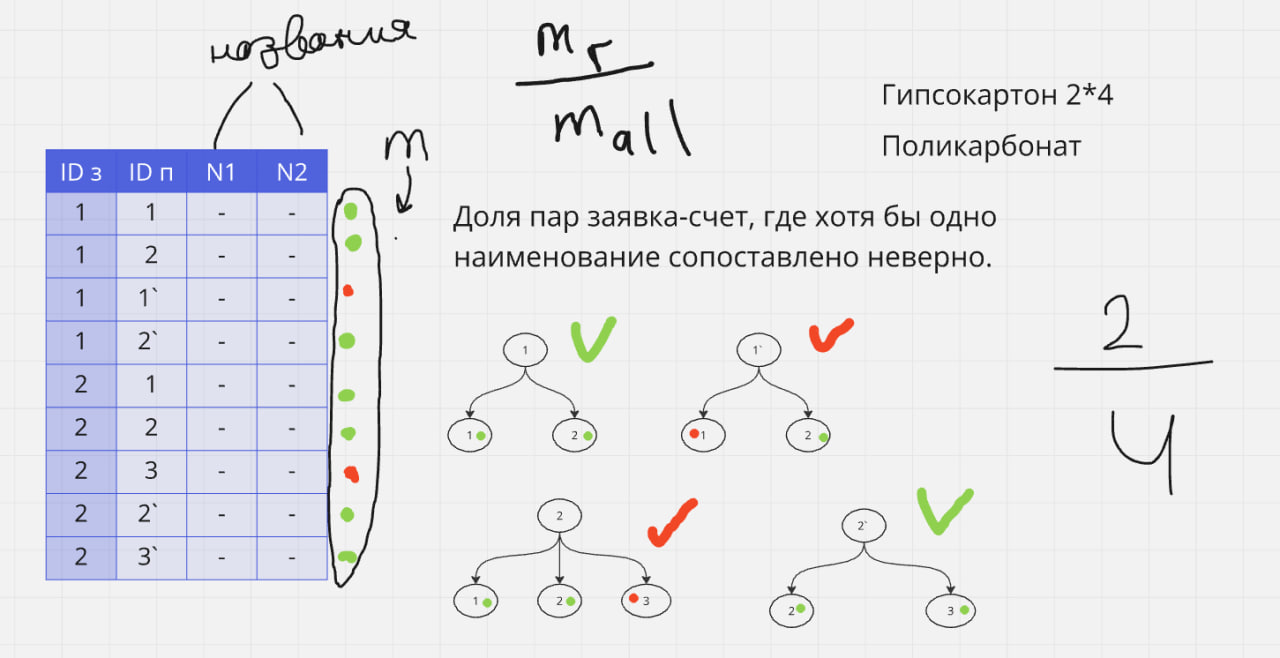

In [49]:
class Mismatch:
  """
  Класс для вычисления доли неверных сопоставлений на уровне позиций и пар заявка-счет.

  Этот класс принимает словарь с корректными сопоставлениями (appl_inv) и предоставляет методы
  для расчета доли неверных сопоставлений на уровне отдельных позиций и доли пар заявка-счет,
  где хотя бы одно наименование сопоставлено неверно.
  """
  def __init__(self, appl_inv: dict):
      self.appl_inv = appl_inv

  def mismatch_rate(self, matches: list) -> float:
      """
      Вычисляет долю неверно сопоставленных наименований в выборке.

      :param matches: Список словарей, содержащих идентификаторы позиций заявки и сопоставленных им позиций счета.
      :return: Доля неверных сопоставлений (float), число от 0 до 1.
      """

      total_count, incorrect_count = 0, 0

      for match_i in matches:
          application_id = match_i['application_id_position']
          invoices_ids = [invoice['invoices_id'] for invoice in match_i['invoices']]
          if application_id in self.appl_inv:
              correct_invoices = self.appl_inv[application_id]
              for invoice_id in invoices_ids:
                  total_count += 1
                  if invoice_id not in correct_invoices:
                      incorrect_count += 1
          else:
              incorrect_count += len(invoices_ids)
              total_count += len(invoices_ids)

      return incorrect_count / total_count if total_count > 0 else 0.0

  def mismatch_pair_rate(self, matches: list) -> float:
      """
      Вычисляет долю пар заявка-счет, где хотя бы одно наименование сопоставлено неверно.

      :param matches: Список словарей, содержащих идентификаторы позиций заявки и сопоставленных им позиций счета.
      :return: Доля пар заявка-счет, где хотя бы одно наименование сопоставлено неверно (float), число от 0 до 1.
      """

      total_pairs, incorrect_pairs = len(matches), 0

      for match_i in matches:
          application_id = match_i['application_id_position']
          invoices_ids = [invoice['invoices_id'] for invoice in match_i['invoices']]

          if application_id not in self.appl_inv:
              incorrect_pairs += 1
              continue

          correct_invoices = self.appl_inv[application_id]

          if any(invoice_id not in correct_invoices for invoice_id in invoices_ids):
              incorrect_pairs += 1

      return incorrect_pairs / total_pairs if total_pairs > 0 else 0.0

In [50]:
# тестирование класса
appl_inv = {
    12897510: [22584294, 22584291],
    12897511: [22584295]
}

matches = [
    {'application_id_position': 12897510, 'invoices': [{"invoices_id": 22584294}, {"invoices_id": 22584291}]},
    {'application_id_position': 12897511, 'invoices': [{"invoices_id": 22584294}, {"invoices_id": 22584295}]}
]

calculator = Mismatch(appl_inv)

print(f"Доля неверных сопоставлений: {calculator.mismatch_rate(matches)}")
print(f"Доля пар с неверными сопоставлениями: {calculator.mismatch_pair_rate(matches)}")

Доля неверных сопоставлений: 0.25
Доля пар с неверными сопоставлениями: 0.5


In [51]:
class Mismatch:
    """
    Класс для вычисления доли неверных сопоставлений на уровне позиций и пар заявка-счет.

    Этот класс принимает словарь с корректными сопоставлениями (appl_inv) и предоставляет методы
    для расчета доли неверных сопоставлений на уровне отдельных позиций и доли пар заявка-счет,
    где хотя бы одно наименование сопоставлено неверно.
    """
    def __init__(self, appl_inv: dict):
        self.appl_inv = appl_inv

    def mismatch_rate(self, matches: list) -> float:
        """
        Вычисляет долю неверно сопоставленных наименований в выборке.

        :param matches: Список словарей, содержащих идентификаторы позиций заявки и сопоставленных им позиций счета.
        :return: Доля неверных сопоставлений (float), число от 0 до 1.
        """

        total_count, incorrect_count = 0, 0

        for match_i in matches:
            application_id = match_i['id']
            invoices_ids = match_i['invoices_ids']
            if application_id in self.appl_inv:
                correct_invoices = self.appl_inv[application_id]
                for invoice_id in invoices_ids:
                    total_count += 1
                    if invoice_id not in correct_invoices:
                        incorrect_count += 1
            else:
                incorrect_count += len(invoices_ids)
                total_count += len(invoices_ids)

        return incorrect_count / total_count if total_count > 0 else 0.0

    def mismatch_pair_rate(self, matches: list) -> float:
        """
        Вычисляет долю пар заявка-счет, где хотя бы одно наименование сопоставлено неверно.

        :param matches: Список словарей, содержащих идентификаторы позиций заявки и сопоставленных им позиций счета.
        :return: Доля пар заявка-счет, где хотя бы одно наименование сопоставлено неверно (float), число от 0 до 1.
        """

        total_pairs, incorrect_pairs = len(matches), 0

        for match_i in matches:
            application_id = match_i['id']
            invoices_ids = match_i['invoices_ids']

            if application_id not in self.appl_inv:
                incorrect_pairs += 1
                continue

            correct_invoices = self.appl_inv[application_id]

            if any(invoice_id not in correct_invoices for invoice_id in invoices_ids):
                incorrect_pairs += 1

        return incorrect_pairs / total_pairs if total_pairs > 0 else 0.0


In [52]:
matches = [
    {
        "id": 12917012,
        "invoices_ids": [22279317]
    },
    {
        "id": 12917010,
        "invoices_ids": [22279319]
    },
    {
        "id": 12917060,
        "invoices_ids": [22279315]
    },
    {
        "id": 12917001,
        "invoices_ids": [22279374]
    },
    {
        "id": 12917052,
        "invoices_ids": [22279754]
    },
    {
        "id": 12917003,
        "invoices_ids": [22279375]
    },
    {
        "id": 12917004,
        "invoices_ids": [22280882]
    },
    {
        "id": 12917005,
        "invoices_ids": []
    },
    {
        "id": 12917015,
        "invoices_ids": []
    },
    {
        "id": 12917011,
        "invoices_ids": [22279740]
    },
    {
        "id": 12917013,
        "invoices_ids": [22279318]
    },
    {
        "id": 12917014,
        "invoices_ids": [22279312]
    },
    {
        "id": 12917009,
        "invoices_ids": [22279738]
    },
    {
        "id": 12917006,
        "invoices_ids": [22279311]
    },
    {
        "id": 12917012,
        "invoices_ids": [22279317]
    },
    {
        "id": 12917037,
        "invoices_ids": [22279730]
    },
    {
        "id": 12917040,
        "invoices_ids": []
    },
    {
        "id": 12917039,
        "invoices_ids": []
    },
    {
        "id": 12917045,
        "invoices_ids": []
    },
    {
        "id": 12917046,
        "invoices_ids": []
    },
    {
        "id": 12917049,
        "invoices_ids": []
    },
    {
        "id": 12917050,
        "invoices_ids": []
    },
    {
        "id": 12917056,
        "invoices_ids": []
    },
    {
        "id": 12917061,
        "invoices_ids": []
    },
    {
        "id": 12917038,
        "invoices_ids": []
    },
    {
        "id": 12917042,
        "invoices_ids": []
    },
    {
        "id": 12917044,
        "invoices_ids": []
    },
    {
        "id": 12917047,
        "invoices_ids": []
    },
    {
        "id": 12917048,
        "invoices_ids": []
    },
    {
        "id": 12917053,
        "invoices_ids": []
    },
    {
        "id": 12917054,
        "invoices_ids": []
    },
    {
        "id": 12917055,
        "invoices_ids": []
    },
    {
        "id": 12917057,
        "invoices_ids": []
    },
    {
        "id": 12917058,
        "invoices_ids": []
    },
    {
        "id": 12917059,
        "invoices_ids": []
    },
    {
        "id": 12917062,
        "invoices_ids": []
    },
    {
        "id": 12917063,
        "invoices_ids": []
    },
    {
        "id": 12917064,
        "invoices_ids": []
    },
    {
        "id": 12917065,
        "invoices_ids": []
    },
    {
        "id": 12917066,
        "invoices_ids": []
    },
    {
        "id": 12917067,
        "invoices_ids": []
    },
    {
        "id": 12917068,
        "invoices_ids": []
    },
    {
        "id": 12917069,
        "invoices_ids": []
    },
    {
        "id": 12917070,
        "invoices_ids": []
    },
    {
        "id": 12917071,
        "invoices_ids": []
    },
    {
        "id": 12917072,
        "invoices_ids": []
    },
    {
        "id": 12917073,
        "invoices_ids": []
    },
    {
        "id": 12917074,
        "invoices_ids": []
    },
    {
        "id": 12917075,
        "invoices_ids": []
    },
    {
        "id": 12917076,
        "invoices_ids": []
    },
    {
        "id": 12917077,
        "invoices_ids": []
    },
    {
        "id": 12917078,
        "invoices_ids": []
    },
    {
        "id": 12917079,
        "invoices_ids": []
    },
    {
        "id": 12917080,
        "invoices_ids": []
    },
    {
        "id": 12917081,
        "invoices_ids": []
    },
    {
        "id": 12917082,
        "invoices_ids": []
    },
    {
        "id": 12917083,
        "invoices_ids": []
    },
    {
        "id": 12917084,
        "invoices_ids": []
    },
    {
        "id": 12917085,
        "invoices_ids": []
    },
    {
        "id": 12917086,
        "invoices_ids": []
    },
    {
        "id": 12917087,
        "invoices_ids": []
    },
    {
        "id": 12917088,
        "invoices_ids": []},
    {
        "id": 12917089,
        "invoices_ids": []
    },
    {
        "id": 12917090,
        "invoices_ids": []
    },
    {
        "id": 12917091,
        "invoices_ids": []
    },
    {
        "id": 12917092,
        "invoices_ids": []
    },
    {
        "id": 12917093,
        "invoices_ids": []
    },
    {
        "id": 12917094,
        "invoices_ids": []
    },
    {
        "id": 12917095,
        "invoices_ids": []
    },
    {
        "id": 12917096,
        "invoices_ids": []
    },
    {
        "id": 12917097,
        "invoices_ids": []
    },
    {
        "id": 12917098,
        "invoices_ids": []
    },
    {
        "id": 12917099,
        "invoices_ids": []
    },
    {
        "id": 12917100,
        "invoices_ids": []
    }
]



In [53]:
calculator = Mismatch(appl_inv)

print(f"Доля неверных сопоставлений: {calculator.mismatch_rate(matches)}")
print(f"Доля пар с неверными сопоставлениями: {calculator.mismatch_pair_rate(matches)}")

Доля неверных сопоставлений: 1.0
Доля пар с неверными сопоставлениями: 1.0


In [54]:
matches =[
    {
        "id": 12917012,
        "invoices_ids": [22279317]
    },
    {
        "id": 12917010,
        "invoices_ids": [22279319]
    },
    {
        "id": 12917060,
        "invoices_ids": [22279315]
    },
    {
        "id": 12917001,
        "invoices_ids": [22279375, 22279751]
    },
    {
        "id": 12917002,
        "invoices_ids": [22279371]
    },
    {
        "id": 12917004,
        "invoices_ids": [22280882]
    },
    {
        "id": 12917005,
        "invoices_ids": []
    },
    {
        "id": 12917006,
        "invoices_ids": [22279311]
    },
    {
        "id": 12917011,
        "invoices_ids": [22279740]
    },
    {
        "id": 12917012,
        "invoices_ids": [22279317]
    },
    {
        "id": 12917015,
        "invoices_ids": []
    },
    {
        "id": 12917037,
        "invoices_ids": [22279730]
    },
    {
        "id": 12917049,
        "invoices_ids": [22279371]
    },
    {
        "id": 12917052,
        "invoices_ids": [22280882]
    },
    {
        "id": 12917056,
        "invoices_ids": []
    },
    {
        "id": 12917061,
        "invoices_ids": [22279311]
    }
]
calculator = Mismatch(appl_inv)

print(f"Доля неверных сопоставлений: {calculator.mismatch_rate(matches)}")
print(f"Доля пар с неверными сопоставлениями: {calculator.mismatch_pair_rate(matches)}")

Доля неверных сопоставлений: 1.0
Доля пар с неверными сопоставлениями: 1.0


In [55]:
# kailo токен
TOKEN = '1000167193.106021.WTg8luT5lomWiCYrj4ZYLS9qRHrPrUDnrWoFc3x3'

In [142]:
def fetch_completion(prompt):
  url = "https://caila.io/api/adapters/openai/chat/completions"
  headers = {
      'Authorization': TOKEN,
      'Content-Type': 'application/json',
  }
  data = {
      "model": "just-ai/openai-proxy/gpt-4o-mini",
      "messages": [{"role": "user", "content": prompt}],
      "temperature": 0,
      "stream": False
  }

  try:
      response = requests.post(url, headers=headers, json=data)
      response.raise_for_status()

      response_data = response.json()

      full_text = response_data.get('choices')[0].get('message').get('content')

      matchs = re.findall(r'\{\s*"id":\s*(\d+),\s*"invoices_ids":\s*\[(.*?)\]\s*\}', full_text)
      result = []
      for m in matchs:
            id_ = int(m[0])
            invoices_ids = [int(x) for x in m[1].split(',') if x.strip().isdigit()]
            result.append({
                "id": id_,
                "invoices_ids": invoices_ids
            })

      input_tokens = response_data.get('usage').get('prompt_tokens', 0)
      output_tokens = response_data.get('usage').get('completion_tokens', 0)
      model = response_data.get('model', 'gpt-3.5-turbo')

      encoding = tiktoken.encoding_for_model("gpt-4")
      c_input_tokens = len(encoding.encode(prompt))
      # output_tokens_count = len(encoding.encode(full_text))
      cost = 0.150
      input_all_cost = (c_input_tokens / 1000000) * cost * 91.11

      return {
          "full_text": result,
          "input_tokens": input_tokens,
          # "output_tokens": output_tokens,
          "cost": round(input_all_cost, 6),
          "model": model
      }
  except Exception as e:
      return {"error": str(e)}

In [143]:
fetch_completion('Привет, придумай рифму к слову Артур')

{'full_text': [], 'input_tokens': 20, 'cost': 0.00026, 'model': 'gpt-4o-mini'}

In [144]:
test_json="""
{
    "application_id": 12869378,
    "application": [
        {
            "position_id": 12916959,
            "name_in_application": "Прокладка РТИ для люка F50.0909",
            "quantity": 263.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916939,
            "name_in_application": "Труба профильная F50.0503 RAL7024",
            "quantity": 217.6,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916977,
            "name_in_application": "Прокладка РТИ для люка W62.0907",
            "quantity": 12.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916961,
            "name_in_application": "Прокладка РТИ для люка F50.0925",
            "quantity": 32.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916968,
            "name_in_application": "Прокладка РТИ для люка FRK 42",
            "quantity": 232.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916953,
            "name_in_application": "Прокладка РТИ для люка 100X38X1",
            "quantity": 600.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916924,
            "name_in_application": "Труба профильная W62.0204 RAL7024",
            "quantity": 169.0,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916969,
            "name_in_application": "Прокладка РТИ для люка FRK 52",
            "quantity": 68.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916998,
            "name_in_application": "Резиновый уплотнитель РТИ FRK 24",
            "quantity": 550.0,
            "unit_of_measurement": "м.п.",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916979,
            "name_in_application": "Прокладка РТИ для люка W62.0951-01",
            "quantity": 120.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12917012,
            "name_in_application": "Дверная ручка 1002.00",
            "quantity": 17.0,
            "unit_of_measurement": "шт",
            "category": "Фурнитура для окон и дверей"
        },
        {
            "position_id": 12916993,
            "name_in_application": "Резиновый уплотнитель РТИ FRK 131",
            "quantity": 100.0,
            "unit_of_measurement": "м.п.",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916996,
            "name_in_application": "Резиновый уплотнитель РТИ FRK 17",
            "quantity": 250.0,
            "unit_of_measurement": "м.п.",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916932,
            "name_in_application": "Труба профильная W62.0130 RAL7024",
            "quantity": 84.5,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916926,
            "name_in_application": "Труба профильная W62.0301 RAL7024",
            "quantity": 32.5,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12917059,
            "name_in_application": "Дверная ручка 3009.00",
            "quantity": 71.0,
            "unit_of_measurement": "шт",
            "category": "Фурнитура для окон и дверей"
        },
        {
            "position_id": 12916920,
            "name_in_application": "Труба профильная C48.0614",
            "quantity": 6.5,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916989,
            "name_in_application": "Прокладка РТИ для люка W62.0957",
            "quantity": 1052.0,
            "unit_of_measurement": "шт",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916941,
            "name_in_application": "Труба профильная F50.0601R",
            "quantity": 272.0,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916925,
            "name_in_application": "Труба профильная W62.0205 RAL7024",
            "quantity": 97.5,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916994,
            "name_in_application": "Резиновый уплотнитель РТИ FRK 14",
            "quantity": 200.0,
            "unit_of_measurement": "м.п.",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12916936,
            "name_in_application": "Труба профильная F50.0303",
            "quantity": 20.4,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        },
        {
            "position_id": 12917042,
            "name_in_application": "Прокладка РТИ для люка C43.0905",
            "quantity": 639.0,
            "unit_of_measurement": "м",
            "category": "Фасадные материалы"
        }
    ],
    "invoices": [
        {
            "position_id": 22279368,
            "name_in_invoice": "Уплотнитель FRK 17 стойка-ригель 9мм.(150м)",
            "quantity": 250.0,
            "unit_of_measurement": "м"
        },
        {
            "position_id": 22279297,
            "name_in_invoice": "Усилитель 64,1 мм. F50,0303 (00) 6,8м.",
            "quantity": 20.4,
            "unit_of_measurement": "м"
        },
        {
            "position_id": 22279290,
            "name_in_invoice": "Порог W62.0802 (00) 6,5м.",
            "quantity": 5.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279369,
            "name_in_invoice": "Уплотнитель FRK 18 стойка-ригель 11мм.(125м)",
            "quantity": 150.0,
            "unit_of_measurement": "м"
        },
        {
            "position_id": 22279363,
            "name_in_invoice": "Угловая закладная W62.0969-02 (00)(49шт)",
            "quantity": 68.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279743,
            "name_in_invoice": "Подкладка опорная С43.0901(50шт)",
            "quantity": 1136.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279300,
            "name_in_invoice": "Крышка декор.12мм. F50,0504 (00) 6,8м.",
            "quantity": 16.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279351,
            "name_in_invoice": "Закладная крепл.импоста W62.0951-01 (00)(100шт)",
            "quantity": 120.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279335,
            "name_in_invoice": "Сухарный элемент F50,0950-01(100шт)",
            "quantity": 80.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279291,
            "name_in_invoice": "Профиль примыкания двери W62.0803 (00) 6.5м.",
            "quantity": 5.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279750,
            "name_in_invoice": "Клей секундный CA-12 (50гр.)(10 шт)",
            "quantity": 15.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279286,
            "name_in_invoice": "Импост W62.0301 (00), 6.5 м",
            "quantity": 5.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279744,
            "name_in_invoice": "Закладная угловая С43.0905 (00)(200шт)",
            "quantity": 639.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279279,
            "name_in_invoice": "Тяга С48,0612 (A00-E6) 6,5м.",
            "quantity": 4.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279325,
            "name_in_invoice": "Подкладка рихтовочная 100*38*3(1000шт)",
            "quantity": 600.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279317,
            "name_in_invoice": "Ручка поворотная с креплением 1002,00 (9005) черн.",
            "quantity": 17.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279315,
            "name_in_invoice": "Ответка шпингалета 3012 (сер) верх. (100шт)",
            "quantity": 17.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279310,
            "name_in_invoice": "Ручка поручень Z10-P 1500 мм. (м.о.переменное) нерж.",
            "quantity": 21.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279374,
            "name_in_invoice": "Уплотнитель FRK 51(125м)",
            "quantity": 100.0,
            "unit_of_measurement": "м"
        },
        {
            "position_id": 22279735,
            "name_in_invoice": "Ручка поручень 500мм.(м.о.переменное) (9006)",
            "quantity": 71.0,
            "unit_of_measurement": "комплект"
        },
        {
            "position_id": 22279287,
            "name_in_invoice": "Импост W62.0302 (00), 6.5 м",
            "quantity": 7.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279745,
            "name_in_invoice": "Заглушка профиля примыкания С43.0906 (00)(100шт)",
            "quantity": 142.0,
            "unit_of_measurement": "шт"
        },
        {
            "position_id": 22279313,
            "name_in_invoice": "Винт анкерный для WALA (тёпл. проф.) WX50SD4980",
            "quantity": 114.0,
            "unit_of_measurement": "шт"
        }
    ]
}
"""

In [145]:
data_json = json.loads(test_json)
application_ids_and_names = [
    {
        "id": item["position_id"],
        "name": item["name_in_application"]
    }
    for item in data_json["application"]
]

invoice_ids_and_names = [
    {
        "id": item["position_id"],
        "name": item["name_in_invoice"]
    }
    for item in data_json["invoices"]
]

In [146]:
application_ids_and_names[: 5]

[{'id': 12916959, 'name': 'Прокладка РТИ для люка F50.0909'},
 {'id': 12916939, 'name': 'Труба профильная F50.0503 RAL7024'},
 {'id': 12916977, 'name': 'Прокладка РТИ для люка W62.0907'},
 {'id': 12916961, 'name': 'Прокладка РТИ для люка F50.0925'},
 {'id': 12916968, 'name': 'Прокладка РТИ для люка FRK 42'}]

In [147]:
invoice_ids_and_names[: 5]

[{'id': 22279368, 'name': 'Уплотнитель FRK 17 стойка-ригель 9мм.(150м)'},
 {'id': 22279297, 'name': 'Усилитель 64,1 мм. F50,0303 (00) 6,8м.'},
 {'id': 22279290, 'name': 'Порог W62.0802 (00) 6,5м.'},
 {'id': 22279369, 'name': 'Уплотнитель FRK 18 стойка-ригель 11мм.(125м)'},
 {'id': 22279363, 'name': 'Угловая закладная W62.0969-02 (00)(49шт)'}]

In [148]:
prompt = """You are a construction procurement specialist, so it is very important for you not to make anything up and only use the information provided to you. Respond only in JSON format. Your task is to match items from two arrays: `application` and `invoices`.

Each item in `invoices` must match exactly one item from `application`. It is possible that multiple `invoices` items correspond to the same `application` item.

Some `application` items may not have a match, in which case, return an empty array for those items.

You should pay close attention to details such as GOST standards, dimensions, and other technical specifications to ensure that items are correctly matched.

Example:
Array A: ["молоток", "кирпич", "плинтус 10"]
Array B: ["плинтус 10", "молоток с деревянной ручкой",  "плинтус 20", "кирпич силикатный", "плинтус 30"]

Result:
- "молоток" -> "молоток с деревянной ручкой"
- "кирпич" -> "кирпич силикатный"
- "плинтус 10" -> "плинтус 10"

Don't output your suggestions, just return the mapping.

Return an array of matches in the following JSON format:
`[{id: <id>, invoices_ids: [<id>] }]`

Input data:
%s"""

In [149]:
print(len(application_ids_and_names))

23


In [150]:
print(len(invoice_ids_and_names))

23


In [151]:
test = {"application": application_ids_and_names,
        "invoices": invoice_ids_and_names
        }

# formatted_prompt = prompt.format(json.dumps(test))
# test_rquest = fetch_completion(formatted_prompt)

test_rquest = fetch_completion(prompt %str(test))

In [156]:
test_rquest['full_text']

[{'id': 12916959, 'invoices_ids': []},
 {'id': 12916939, 'invoices_ids': [22279297]},
 {'id': 12916977, 'invoices_ids': []},
 {'id': 12916961, 'invoices_ids': []},
 {'id': 12916968, 'invoices_ids': []},
 {'id': 12916953, 'invoices_ids': [22279325]},
 {'id': 12916924, 'invoices_ids': []},
 {'id': 12916969, 'invoices_ids': []},
 {'id': 12916998, 'invoices_ids': []},
 {'id': 12916979, 'invoices_ids': [22279351]},
 {'id': 12917012, 'invoices_ids': [22279317]},
 {'id': 12916993, 'invoices_ids': []},
 {'id': 12916996, 'invoices_ids': []},
 {'id': 12916932, 'invoices_ids': [22279286]},
 {'id': 12916926, 'invoices_ids': []},
 {'id': 12917059, 'invoices_ids': []},
 {'id': 12916920, 'invoices_ids': [22279279]},
 {'id': 12916989, 'invoices_ids': []},
 {'id': 12916941, 'invoices_ids': []},
 {'id': 12916925, 'invoices_ids': []},
 {'id': 12916994, 'invoices_ids': []},
 {'id': 12916936, 'invoices_ids': [22279297]},
 {'id': 12917042, 'invoices_ids': []}]

In [154]:
calculator = Mismatch(test_rquest['full_text'])

print(f"Доля неверных сопоставлений: {calculator.mismatch_rate(matches)}")
print(f"Доля пар с неверными сопоставлениями: {calculator.mismatch_pair_rate(matches)}")

Доля неверных сопоставлений: 1.0
Доля пар с неверными сопоставлениями: 1.0


In [161]:
try:
    json_data = json.loads(test_json)
    print(json_data)
except json.JSONDecodeError as e:
    print(f"Ошибка декодирования JSON: {e}")

{'application_id': 12869378, 'application': [{'position_id': 12916959, 'name_in_application': 'Прокладка РТИ для люка F50.0909', 'quantity': 263.0, 'unit_of_measurement': 'шт', 'category': 'Фасадные материалы'}, {'position_id': 12916939, 'name_in_application': 'Труба профильная F50.0503 RAL7024', 'quantity': 217.6, 'unit_of_measurement': 'м', 'category': 'Фасадные материалы'}, {'position_id': 12916977, 'name_in_application': 'Прокладка РТИ для люка W62.0907', 'quantity': 12.0, 'unit_of_measurement': 'шт', 'category': 'Фасадные материалы'}, {'position_id': 12916961, 'name_in_application': 'Прокладка РТИ для люка F50.0925', 'quantity': 32.0, 'unit_of_measurement': 'шт', 'category': 'Фасадные материалы'}, {'position_id': 12916968, 'name_in_application': 'Прокладка РТИ для люка FRK 42', 'quantity': 232.0, 'unit_of_measurement': 'шт', 'category': 'Фасадные материалы'}, {'position_id': 12916953, 'name_in_application': 'Прокладка РТИ для люка 100X38X1', 'quantity': 600.0, 'unit_of_measurement

In [177]:
a_ids = [12916939, 12916953, 12916979, 12917012, 12916932, 12916920, 12916936]
i_ids = [22279297, 22279325, 22279351, 22279317, 22279286, 22279279, 22279297]

a_ids_set = set(a_ids)
i_ids_set = set(i_ids)

a_items_dict = {item['position_id']: item['name_in_application'] for item in json_data['application'] if item['position_id'] in a_ids_set}
i_items_dict = {item['position_id']: item['name_in_invoice'] for item in json_data['invoices'] if item['position_id'] in i_ids_set}

matches = []

for a_id, a_name in a_items_dict.items():
    for i_id in i_ids_set:
        if i_id in i_items_dict:
            matches.append({
                'application_id': a_id,
                'application_name': a_name,
                'invoice_id': i_id,
                'invoice_name': i_items_dict[i_id]
            })
            i_ids_set.remove(i_id)
            break

for match in matches:
    print(f"{match['application_name']} -> {match['invoice_name']}")

Труба профильная F50.0503 RAL7024 -> Усилитель 64,1 мм. F50,0303 (00) 6,8м.
Прокладка РТИ для люка 100X38X1 -> Тяга С48,0612 (A00-E6) 6,5м.
Прокладка РТИ для люка W62.0951-01 -> Ручка поворотная с креплением 1002,00 (9005) черн.
Дверная ручка 1002.00 -> Импост W62.0301 (00), 6.5 м
Труба профильная W62.0130 RAL7024 -> Закладная крепл.импоста W62.0951-01 (00)(100шт)
Труба профильная C48.0614 -> Подкладка рихтовочная 100*38*3(1000шт)
